In [2]:
import numpy as np
from scipy import stats

class BayesLinReg:

    def __init__(self, n_features, alpha, beta):
        self.n_features = n_features
        self.alpha = alpha
        self.beta = beta
        self.mean = np.zeros(n_features)
        self.cov_inv = np.identity(n_features) / alpha

    def learn(self, x, y):

        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.cov_inv + self.beta * np.outer(x, x)

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y * x)

        self.cov_inv = cov_inv
        self.mean = mean

        return self

    def predict(self, x):

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + x @ w_cov @ x.T

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)

    @property
    def weights_dist(self):
        cov = np.linalg.inv(self.cov_inv)
        return stats.multivariate_normal(mean=self.mean, cov=cov)


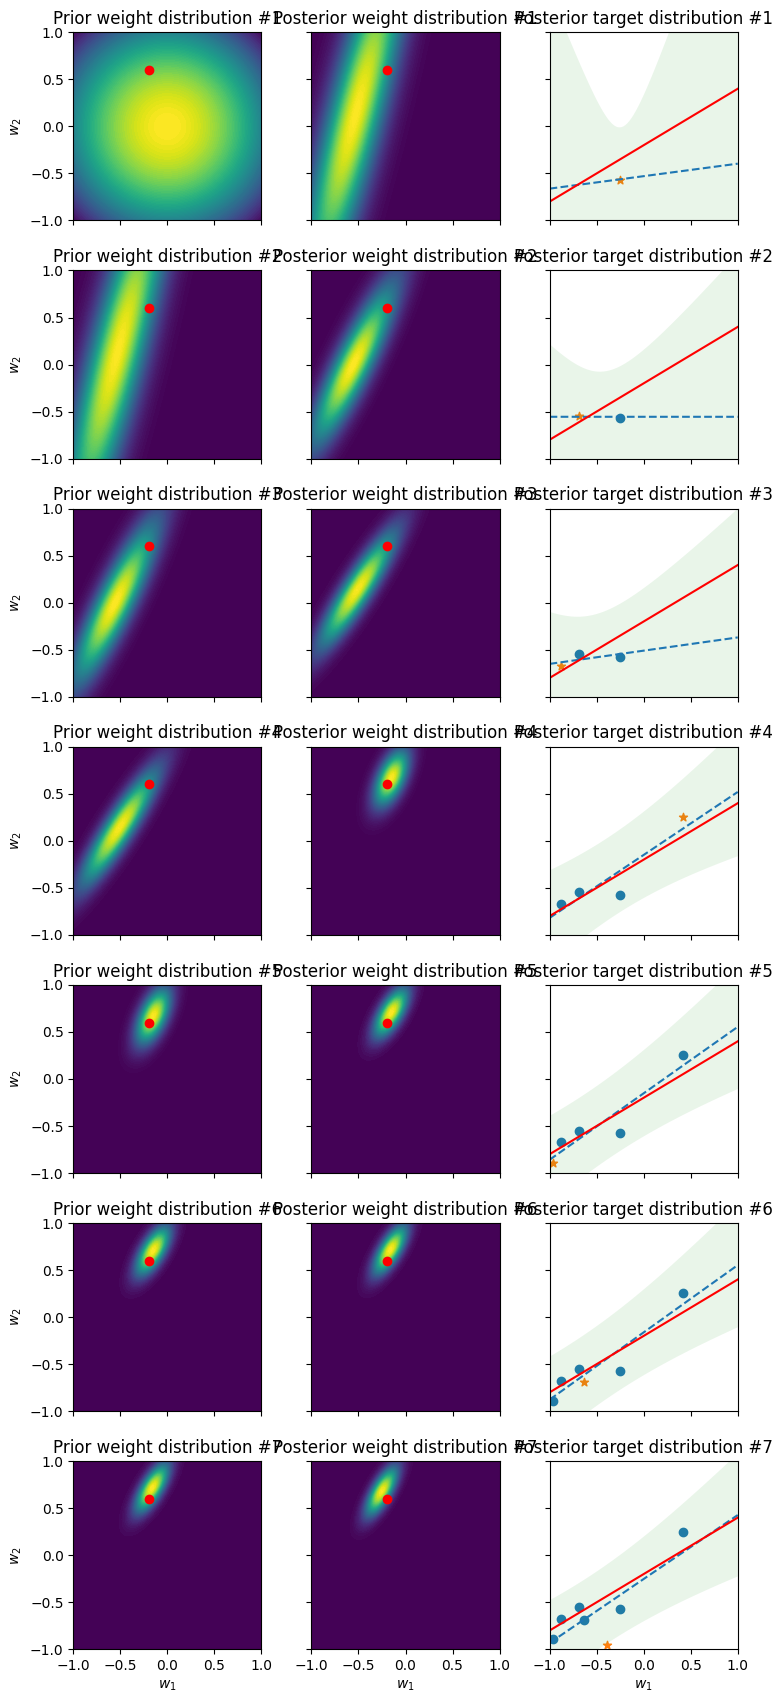

In [55]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

np.random.seed(42)

# Pick some true parameters that the model has to find
weights = np.array([-.2, .6])

def sample(n):
    for _ in range(n):
        x = np.array([1, np.random.uniform(-1, 1)])
        y = np.dot(weights, x) + np.random.normal(0, .2)
        yield x, y

model = BayesLinReg(n_features=2, alpha=2, beta=25)

# The following 3 variables are just here for plotting purposes
N = 100
w = np.linspace(-1, 1, 100)
W = np.dstack(np.meshgrid(w, w))

n_init_samples = 7
fig = plt.figure(figsize=(7 * n_init_samples, 21))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(n_init_samples, 3),  # creates a n_init_samples grid of axes
    axes_pad=.5  # pad between axes in inch.
)

# We'll store the features and targets for plotting purposes
xs = []
ys = []

def prettify_ax(ax):
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('$w_1$')
    ax.set_ylabel('$w_2$')
    return ax

n_samples = 10
init_samples = []
for i, (xi, yi) in enumerate(sample(n_samples)):
    init_samples.append((xi, yi))

for i, (xi, yi) in enumerate(init_samples[0:n_init_samples]):

    pred_dist = model.predict(xi)

    # Prior weight distribution
    ax = prettify_ax(grid[3 * i])
    ax.set_title(f'Prior weight distribution #{i + 1}')
    ax.contourf(w, w, model.weights_dist.pdf(W), N, cmap='viridis')
    ax.scatter(*weights, color='red')  # true weights the model has to find

    # Update model
    model.learn(xi, yi)

    # Prior weight distribution
    ax = prettify_ax(grid[3 * i + 1])
    ax.set_title(f'Posterior weight distribution #{i + 1}')
    ax.contourf(w, w, model.weights_dist.pdf(W), N, cmap='viridis')
    ax.scatter(*weights, color='red')  # true weights the model has to find

    # Posterior target distribution
    xs.append(xi)
    ys.append(yi)
    posteriors = [model.predict(np.array([1, wi])) for wi in w]
    ax = prettify_ax(grid[3 * i + 2])
    ax.set_title(f'Posterior target distribution #{i + 1}')
    # Plot the old points and the new points
    ax.scatter([xi[1] for xi in xs[:-1]], ys[:-1])
    ax.scatter(xs[-1][1], ys[-1], marker='*')
    # Plot the predictive mean along with the predictive interval
    ax.plot(w, [p.mean() for p in posteriors], linestyle='--')
    cis = [p.interval(.95) for p in posteriors]
    ax.fill_between(
        x=w,
        y1=[ci[0] for ci in cis],
        y2=[ci[1] for ci in cis],
        alpha=.1
    )
    # Plot the true target distribution
    ax.plot(w, [np.dot(weights, [1, xi]) for xi in w], color='red')


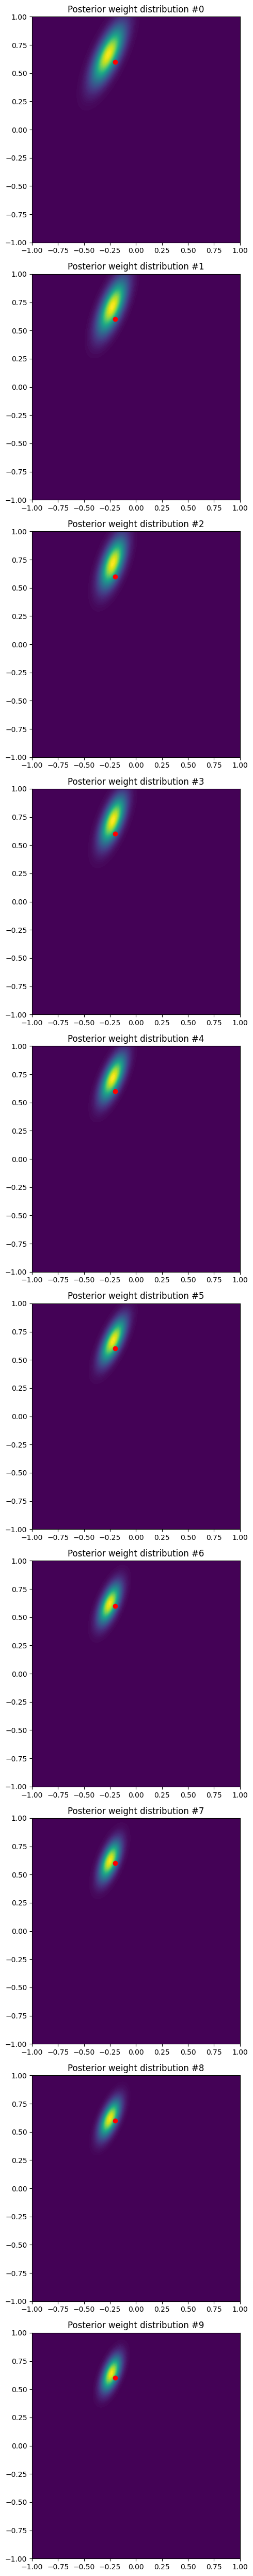

In [56]:
n_plots = 10
fig, ax = plt.subplots(n_plots, 1, figsize=(5, n_plots*5))

further_samples = []
for i, (xi, yi) in enumerate(sample(n_plots)):
    further_samples.append((xi, yi))

for i, (xi, yi) in enumerate(further_samples):
    model.learn(xi, yi)

    ax[i].set_title(f'Posterior weight distribution #{i}')
    ax[i].contourf(w, w, model.weights_dist.pdf(W), N, cmap='viridis')
    ax[i].scatter(*weights, color='red')  # true weights the model has to find

plt.tight_layout()

# Show the plots
plt.show()